## 2. Fundamental_Backtest
选中即买

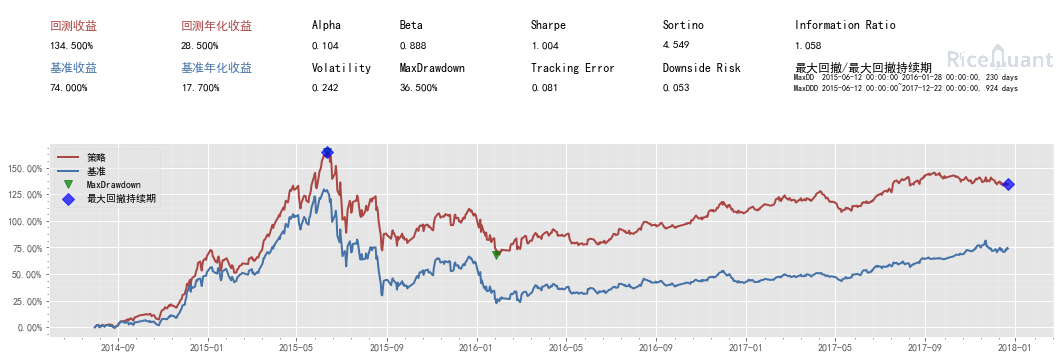

{'sys_analyser': {'benchmark_portfolio':              cash  market_value  static_unit_net_value  total_value  \
  date                                                                  
  2014-08-01  687.4     999312.60                  1.000   1000000.00   
  2014-08-04  687.4    1019140.98                  1.000   1019828.38   
  2014-08-05  687.4    1016451.15                  1.020   1017138.55   
  2014-08-06  687.4    1013821.38                  1.017   1014508.78   
  2014-08-07  687.4     998480.34                  1.015    999167.74   
  2014-08-08  687.4    1000054.77                  0.999   1000742.17   
  2014-08-11  687.4    1014735.15                  1.001   1015422.55   
  2014-08-12  687.4    1011174.45                  1.015   1011861.85   
  2014-08-13  687.4    1011968.10                  1.012   1012655.50   
  2014-08-14  687.4    1002122.55                  1.013   1002809.95   
  2014-08-15  687.4    1012714.56                  1.003   1013401.96   
  2014-08-18

In [2]:
import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *

#读取文件位置
def init(context):
    codes = pd.read_excel('factor.xlsx')
    context.codes = codes.set_index('date')
    scheduler.run_daily(find_pool)


def find_pool(context, bar_dict):
    try:
        codes = context.codes.loc[context.now]
    except KeyError:
        return
    stocks = codes.index[codes == 1]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            if codes not in result and codes not in context.portfolio.positions:
                result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

config = {
  "base": {
    "start_date": "2014-08-01",
    "end_date": "2017-12-22",
    "accounts": {'stock':1000000},
    "benchmark": "000300.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 加入TA择时，降低最大回撤
利用基本面数据选出价值股后，如果MA最近两天连续涨则买入，三天连续跌卖出。

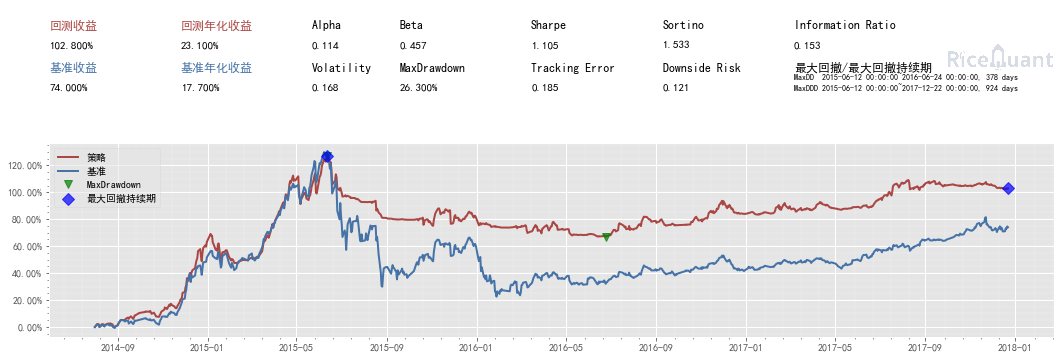

{'sys_analyser': {'benchmark_portfolio':               cash  market_value  static_unit_net_value  total_value  \
  date                                                                   
  2014-08-01  2215.2    9997784.80                  1.000  10000000.00   
  2014-08-04  2215.2   10196161.04                  1.000  10198376.24   
  2014-08-05  2215.2   10169250.20                  1.020  10171465.40   
  2014-08-06  2215.2   10142940.24                  1.017  10145155.44   
  2014-08-07  2215.2    9989458.32                  1.015   9991673.52   
  2014-08-08  2215.2   10005209.96                  0.999  10007425.16   
  2014-08-11  2215.2   10152082.20                  1.001  10154297.40   
  2014-08-12  2215.2   10116458.60                  1.015  10118673.80   
  2014-08-13  2215.2   10124398.80                  1.012  10126614.00   
  2014-08-14  2215.2   10025897.40                  1.013  10028112.60   
  2014-08-15  2215.2   10131866.88                  1.003  10134082.08   

In [3]:
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *

def init(context):
    context.codes = pd.read_excel('factor.xlsx', index_col='date')
    scheduler.run_daily(find_pool)


def find_pool(context, bar_dict):
    try:
        codes = context.codes.loc[context.now]
    except KeyError:
        return
    stocks = codes.index[codes == True]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    sell(context)
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            data_c = history_bars(codes, 42, '1d', 'low', adjust_type='post')
            ma = ta.EMA(data_c, timeperiod=40)
            if len(ma)>3:
                if ma[-1] > ma[-3] and codes not in result and codes not in context.portfolio.positions:
                    result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

def sell(context):
    sell_list = []
    for stocks in context.portfolio.positions:
        data_c = history_bars(stocks, 42, '1d', 'high', adjust_type='post')
        ma = ta.EMA(data_c, timeperiod=40)
        if len(ma)>3:
            if ma[-1] < ma[-3]:
                sell_list.append(stocks)
    if len(sell_list):
        for s in sell_list:
            order_target_percent(s, 0)

config = {
    "base": {
        "start_date": "2014-08-01",
        "end_date": "2017-12-22",
        "frequency": '1d',
        "accounts": {'stock': 10000000},
        "benchmark": "000300.XSHG"
    },
    "extra": {
        "log_level": "error",
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True
        }
    }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)